NB test based on Original NB V4

In [1]:
import os
import sys
import fastai
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

from fastai.imports import *
from fastai.vision import *
from fastai.vision.all import *
from torchvision.models import vgg16_bn
from tqdm import tqdm
from sklearn import preprocessing

In [2]:
## Defining Directories
work_dir = Path('/kaggle/working/')
path = Path('../input/hotel-id-2021-fgvc8')
train = path / 'train_images'
test =  path / 'test_images'
sample_sub = path / 'sample_submission.csv'
labels = path / 'train.csv'

print(train, test, sample_sub, labels)

## Reading csv
train_data = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

train_data.head()
train_data

../input/hotel-id-2021-fgvc8/train_images ../input/hotel-id-2021-fgvc8/test_images ../input/hotel-id-2021-fgvc8/sample_submission.csv ../input/hotel-id-2021-fgvc8/train.csv


image  chain  hotel_id            timestamp
0      8000d59f6a3d765f.jpg     85     24607  2018-11-28 05:42:31
1      8000febe81817f7f.jpg      6     25389  2017-01-01 07:01:46
2      80053befc2d42fba.jpg      3       672  2018-01-26 13:22:07
3      8007fa0a8fe89f9d.jpg      5     63866  2020-07-03 02:31:31
4      800a4a6b6f6d2df6.jpg      0     12036  2017-09-22 17:59:22
...                     ...    ...       ...                  ...
97551  ffff8082ec219892.jpg     83     20544  2016-12-18 03:04:54
97552  ffff8200e50cc0f1.jpg     82     51053  2018-01-23 03:51:42
97553  ffff84129981a4a4.jpg     83     42842  2017-03-30 22:45:24
97554  ffff85015040c2af.jpg     82      6261  2016-11-09 12:34:06
97555  ffffc0c05f2820c1.jpg     79     58764  2017-06-14 21:55:37

[97556 rows x 4 columns]

In [3]:
train_data.columns
len_data = len(train_data['hotel_id'].value_counts())

print("data Length:", len_data)
print("Hotel Chains:",train_data['chain'].unique())
chain_len = len(train_data['chain'].unique())-1
chain_len

data Length: 7770
Hotel Chains: [85  6  3  5  0 82  2 87 90 28 78 89 52 50 83  9 42  8 68 71  4 80 73 55
 66 54  1 76  7 51 40 35 69 45 79 37 64 81 62 75 86 44 63 70 49 61 74 84
 88 67 59 29 32 31 22 20 72 11 34 39 38 41 57 46 65 53 16 60 47 77 30 21
 26 27 10 91 23 24 17 58 48 56 36 33 12 25 13 18]


87

Text(0.5, 1.0, 'Hotels per Chain')

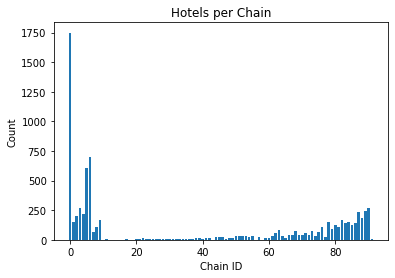

In [4]:
# Hotels per Chain 
hotel_per_chain={}
chains = train_data['chain'].unique()
for chain_id in chains:
    hotel_per_chain[chain_id] = train_data[train_data['chain']==chain_id]['hotel_id'].nunique()

#plot
bar = plt.bar(x=hotel_per_chain.keys(),height=hotel_per_chain.values())
plt.xlabel("Chain ID")
plt.ylabel("Count")
plt.title("Hotels per Chain")

In [5]:
img_fldr = train_data['chain'].astype(str) + '/' + train_data['image']

train_image = []
train_label = []
for i in range(train_data.shape[0]):
#     print(str(train) + "/" + img_fldr[i])
    train_image.append(str(train) + "/" + img_fldr[i])
    train_label.append(img_fldr[i])

x_train = np.array(train_image)
x_label = np.array(train_label)

In [6]:
x_train.shape, x_label.shape

((97556,), (97556,))

In [7]:
train_image[0]

'../input/hotel-id-2021-fgvc8/train_images/85/8000d59f6a3d765f.jpg'

In [8]:
!ls ../input/hotel-id-2021-fgvc8/train_images/

0   13	20  25	3   34	39  44	49  53	58  62	67  71	76  80	85  9
1   16	21  26	30  35	4   45	5   54	59  63	68  72	77  81	86  90
10  17	22  27	31  36	40  46	50  55	6   64	69  73	78  82	87  91
11  18	23  28	32  37	41  47	51  56	60  65	7   74	79  83	88
12  2	24  29	33  38	42  48	52  57	61  66	70  75	8   84	89


In [9]:
!ls ../input/hotel-id-2021-fgvc8/train_images/3 | wc -l

5398


In [10]:
!ls ../input/hotel-id-2021-fgvc8/train_images/3

80053befc2d42fba.jpg  a7015cbc432eabd9.jpg  d063ed0cc2f01cef.jpg
800a7ffa85c57a3a.jpg  a7198aa6e1de1b0d.jpg  d06aa5879ee06765.jpg
802beb5ad6256d35.jpg  a73ef0e3f003f860.jpg  d06b1dd60aadf8e0.jpg
8035ee81817f7f68.jpg  a75f2a95aa427591.jpg  d06bd01666ed057e.jpg
803e97593d9ec1e1.jpg  a7769520672ee02f.jpg  d06ef1b16a91de42.jpg
804d379bd257ad8a.jpg  a7869878a8649f5b.jpg  d0746f8f93f0404f.jpg
80557fae28a9e1d5.jpg  a78dca7c96f150c8.jpg  d07a2f85177ae825.jpg
805ae592e1967bd5.jpg  a79952d611c850ff.jpg  d07a6b8507be7825.jpg
805bae9bc4a47ba6.jpg  a799fce24b1c382a.jpg  d07a7f9407cb8097.jpg
8068a45f6bd59a37.jpg  a79cc3e19c83a56a.jpg  d07b47a05e90be55.jpg
8071edcdad2464db.jpg  a7a60759494d7f30.jpg  d07bec052ab8d07b.jpg
80751e8f9f8e8599.jpg  a7a733c3d8383037.jpg  d081bc7a07dc19ee.jpg
807692e95f72ad19.jpg  a7ababdd4a350a18.jpg  d0873633cf36318d.jpg
8078f3879ffc604a.jpg  a7b4855bd08f90e9.jpg  d090952557b6a5af.jpg
807a9fc06c3793e9.jpg  a7c538196ac29d3e.jpg  d090af6fd31c701b.jpg
807aced6caa452ed.jpg  a7c

In [11]:
print(train)

../input/hotel-id-2021-fgvc8/train_images


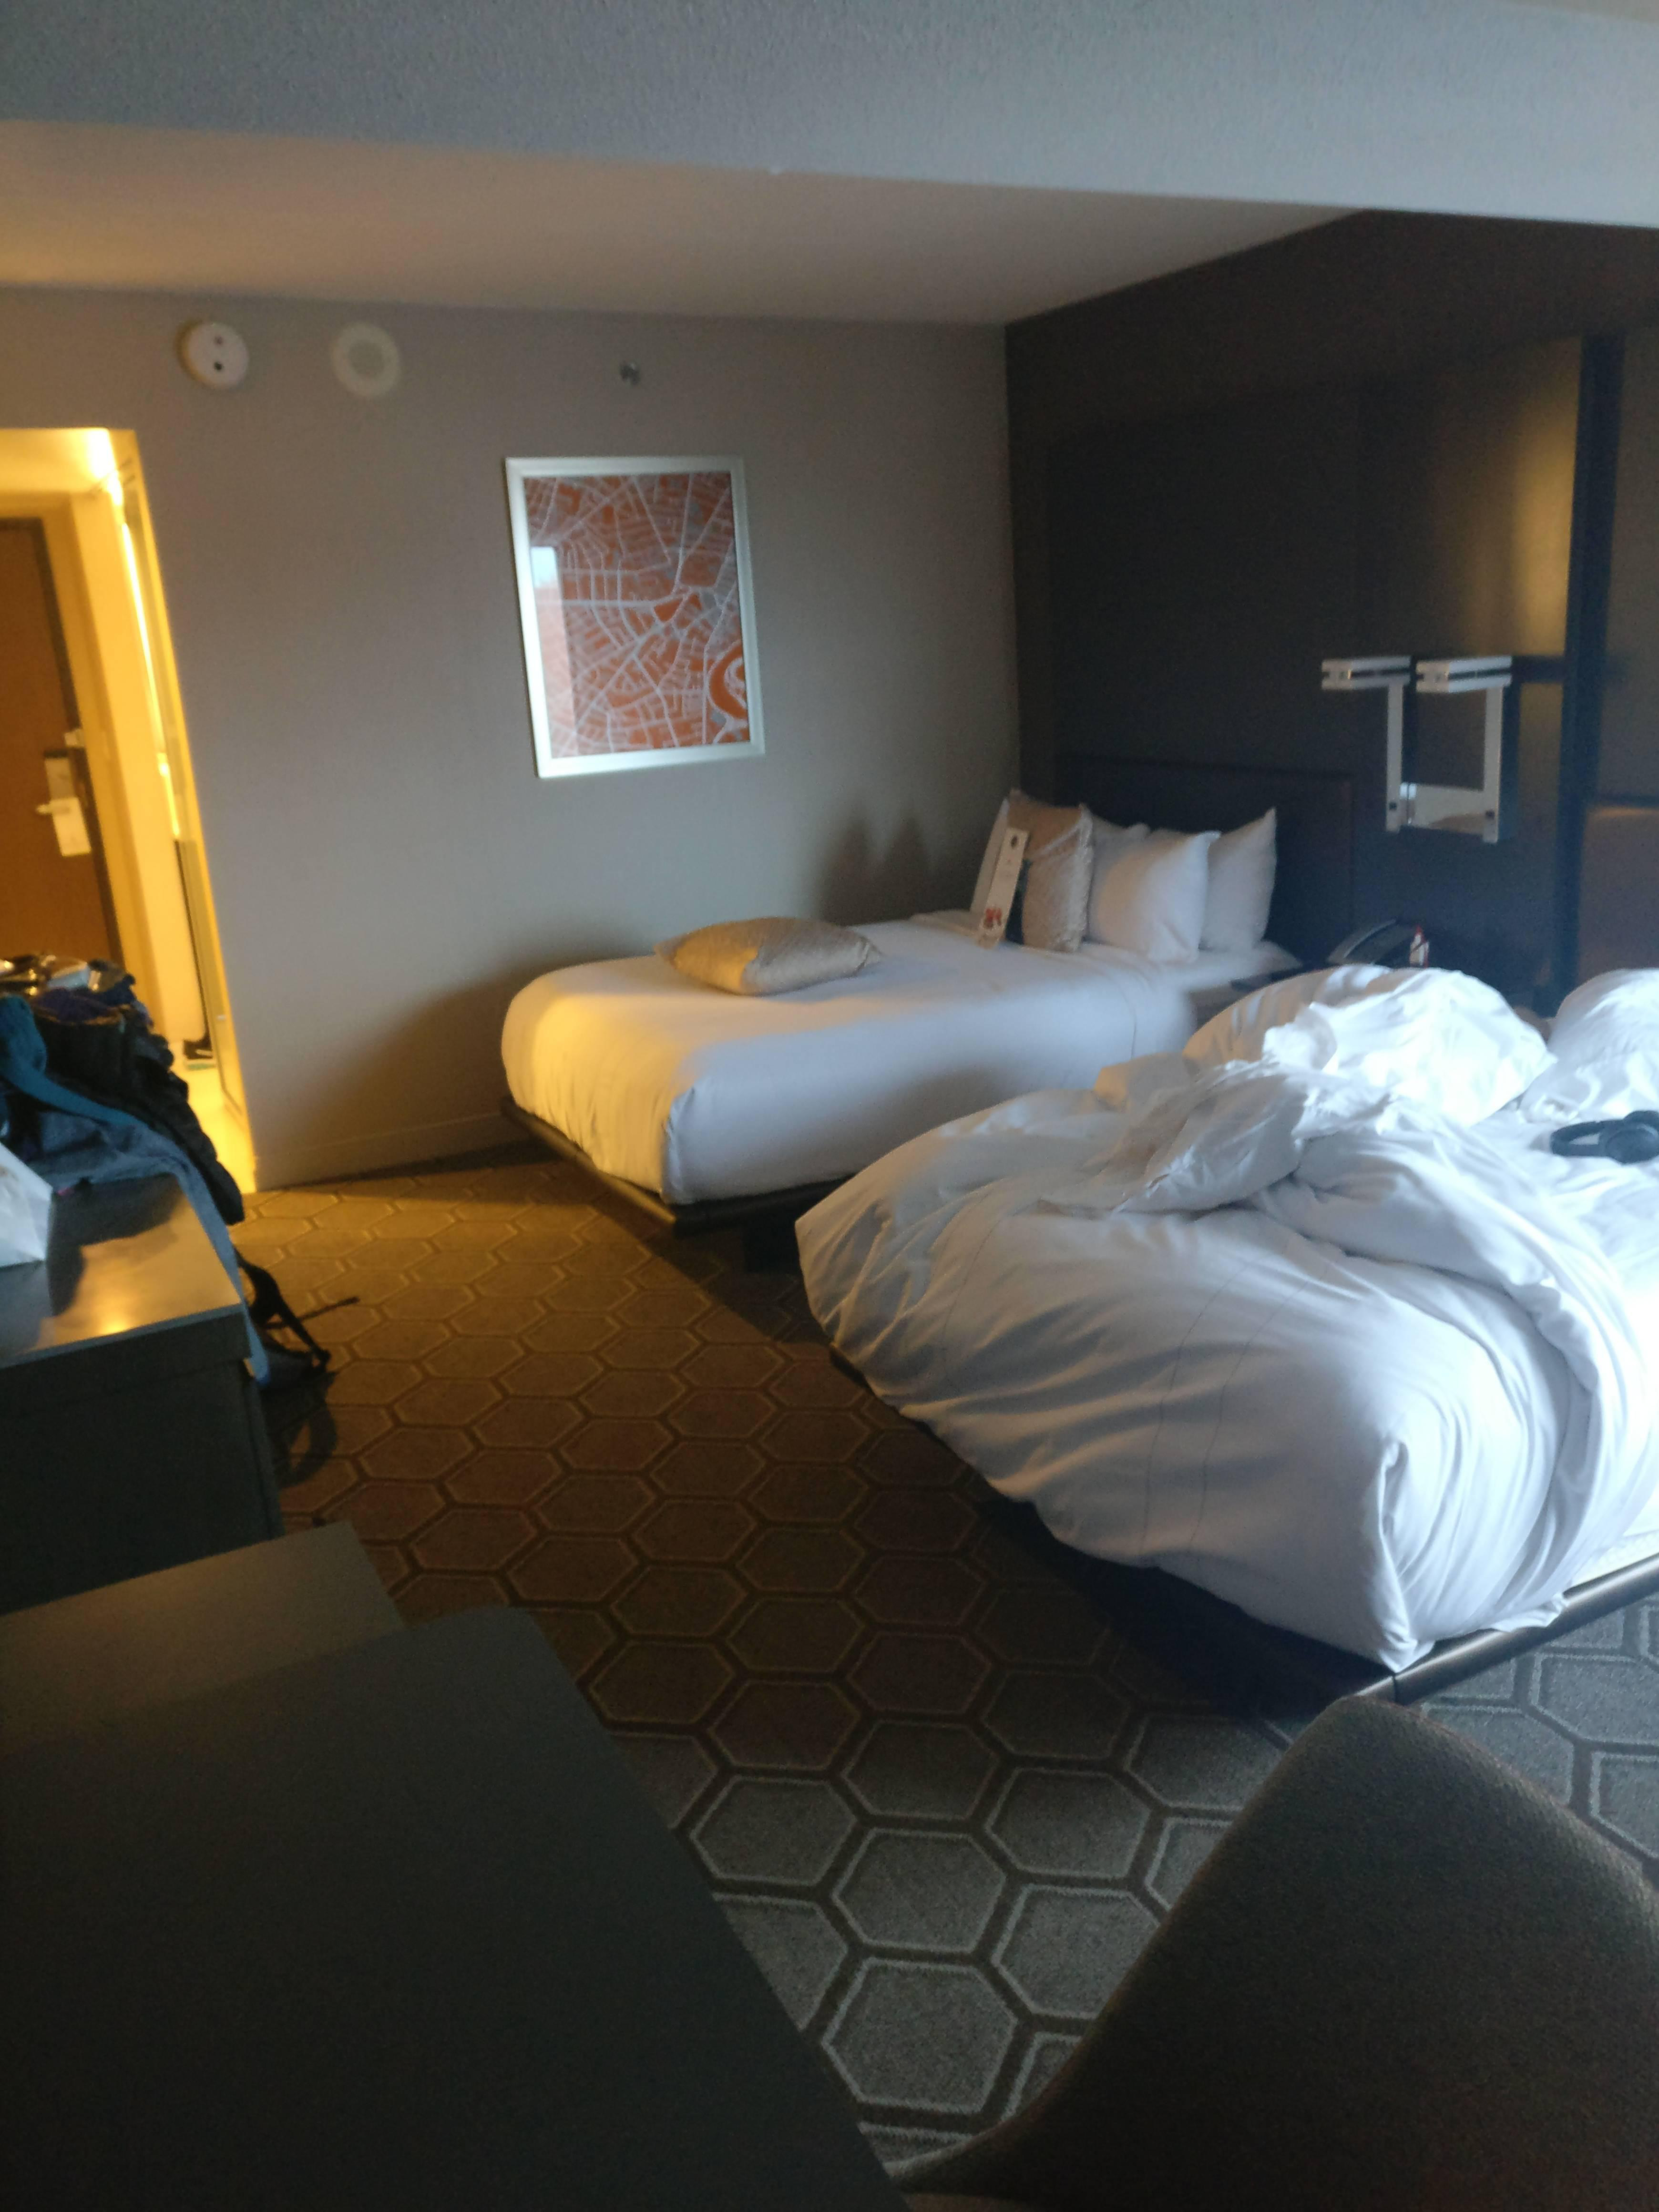

In [12]:
fn = train / '3/a8c65bb390d425bb.jpg'
img = PIL.Image.open(fn)
img

In [13]:
img.shape

(4640, 3480)

In [14]:
resize_to??

In [15]:
size = 224
targ_sz = resize_to(img, size)
targ_sz

(168, 224)

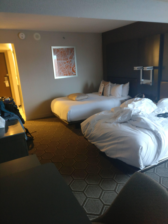

In [16]:
img_rsz = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
img_rsz = img_rsz.convert('RGB')
img_rsz

In [17]:
# we compute the tensor (of floats) from the image and send it to the gpu
im = image2tensor(img_rsz).float().cuda()

### Extract feature vector for an tensor representing an image

In [18]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [19]:
def compute_features(x, feature_extractor, layer_ids, clone=False):
    features = [feature_extractor[i] for i in layer_ids]
    hooks = hook_outputs(features, detach=False)
    feature_extractor(x)
    features_x = [(o.clone() if clone else o) for o in hooks.stored]
    return features_x


def compute_feature_vector(x, feature_extractor, layer_ids, clone=False):
    features_x = compute_features(x, feature_extractor, layer_ids, clone)
    # Computing the Gram Matrix for the features
    gmv = [gram_matrix(e) for e in features_x]
    # flat to get single vector
    gmv_flat_vector = torch.cat([torch.flatten(g) for g in gmv])
    return gmv_flat_vector

In [20]:
# using a vgg16 network as feature extractor
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m.requires_grad_(False);

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [21]:
vgg_m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [22]:
requires_grad(vgg_m)

False

In [23]:
# blocks (i.e., layers) to use for the feature extraction

blocks = [i-1 for i,o in enumerate(children_and_parameters(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [24]:
#  we need to unsqueeze to do a forward pass of a 1-image-batch through the network
im.unsqueeze(0).shape

torch.Size([1, 3, 224, 168])

In [25]:
v = compute_feature_vector(im.unsqueeze(0), vgg_m, blocks)

In [26]:
# Computing the Gram Matrix for the features
gmv = [gram_matrix(e) for e in v]

ValueError: not enough values to unpack (expected 4, got 0)

In [27]:
[g.shape for g in gmv]

NameError: name 'gmv' is not defined

In [28]:
# flatten the matrices and concatenate them to get a single "feature vector"
gmv_flat_vector = torch.cat([torch.flatten(g) for g in gmv])

NameError: name 'gmv' is not defined

In [29]:
gmv_flat_vector

NameError: name 'gmv_flat_vector' is not defined

In [30]:
gmv_flat_vector.shape

NameError: name 'gmv_flat_vector' is not defined

### This is the method we want to use to extract the feature vectors for each image

In [31]:
vx = compute_feature_vector(im.unsqueeze(0), vgg_m, blocks)

In [32]:
#testing if same vector: norm of the difference == 0
(gmv_flat_vector - vx).cpu().norm()

NameError: name 'gmv_flat_vector' is not defined